<a href="https://colab.research.google.com/github/ahmadizza/Sentiment-Analysis-using-RNN-vs-LSTM-IMDB-Reviews-/blob/main/Sentiment_Analysis_using_RNN_vs_LSTM_(IMDB_Reviews).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Nama                          | NIM            |
| ----------------------------- | -------------- |
| Ahmad Izza                    | 11220940000006 |
| Dani Hidayat                  | 11220940000014 |


# Importing Library

In [ ]:
import re
import nltk
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from wordcloud import WordCloud
from collections import Counter
from torch.utils.data import Dataset, DataLoader

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('punkt_tab')

plt.style.use('default')    # Reset style matplotlib
plt.rcdefaults()            # Reset rcParams ke default
sns.reset_defaults()        # Reset style seaborn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Explore The Data

In [ ]:
df = pd.read_csv("https://drive.google.com/uc?id=1EGuTr5JIsFi-2a-tUNCIM-0EL5pZBStm")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
print(df.info())
df['sentiment'] = df['sentiment'].astype("category")
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   review     50000 non-null  object  
 1   sentiment  50000 non-null  category
dtypes: category(1), object(1)
memory usage: 439.7+ KB
None


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
negative,25000
positive,25000


In [ ]:
df.describe(include='all')

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [ ]:
# Check missing values
print(df.isnull().sum())

# Check for duplicate rows
print("Duplicates:", df.duplicated().sum())

# Drop duplicates if any
df.drop_duplicates(inplace=True)

review       0
sentiment    0
dtype: int64
Duplicates: 418


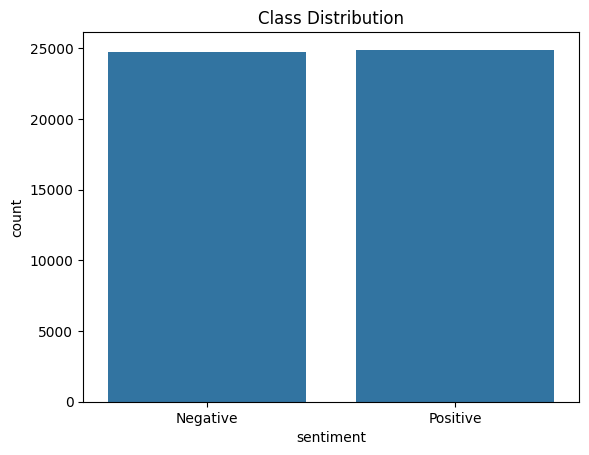

In [ ]:
sns.countplot(data=df, x='sentiment')
plt.title("Class Distribution")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

count    49582.000000
mean       231.350167
std        171.542020
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: review_length, dtype: float64


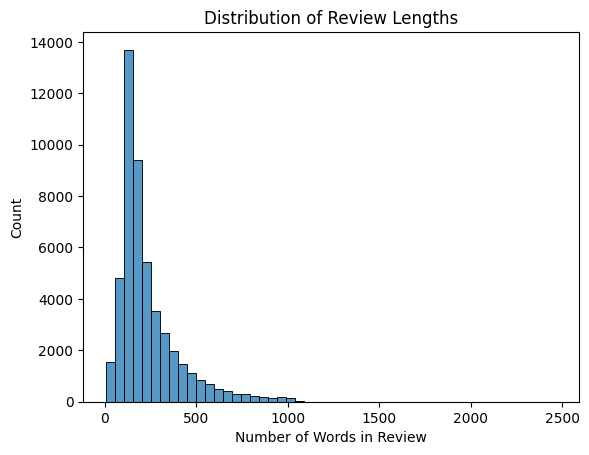

In [ ]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Describe lengths
print(df['review_length'].describe())

# Plot histogram
sns.histplot(df['review_length'], bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words in Review")
plt.show()

# Pre-Processing

## Easy Cleaning Review

In [ ]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    words = word_tokenize(text)

    # Remove stopwords
    filtered = [word for word in words if word not in stop_words]

    return " ".join(filtered)

In [ ]:
df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].head()

,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


## Encoding Sentiment

In [ ]:
df['encode_sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df

,review,sentiment,review_length,clean_review,encode_sentiment
0,One of the other reviewers has mentioned that ...,positive,307,one reviewers mentioned watching oz episode yo...,1
1,A wonderful little production. <br /><br />The...,positive,162,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,positive,166,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,138,basically theres family little boy jake thinks...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love time money visually stunni...,1
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,194,thought movie right good job wasnt creative or...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,112,bad plot bad dialogue bad acting idiotic direc...,0
49997,I am a Catholic taught in parochial elementary...,negative,230,catholic taught parochial elementary schools n...,0
49998,I'm going to have to disagree with the previou...,negative,212,im going disagree previous comment side maltin...,0


## Splitting Data (Trainig, Validation, Test)

In [ ]:
# Shuffle data
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Split 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['sentiment'])

# Cek distribusi label di tiap set
print("Train:", train_df['sentiment'].value_counts())
print("Val:", val_df['sentiment'].value_counts())
print("Test:", test_df['sentiment'].value_counts())

Train: sentiment
positive    19907
negative    19758
Name: count, dtype: int64
Val: sentiment
positive    2488
negative    2470
Name: count, dtype: int64
Test: sentiment
positive    2489
negative    2470
Name: count, dtype: int64


## Tokenisasi Text

In [ ]:
# 1. Siapkan data teks
train_texts = train_df['review'].tolist()
val_texts = val_df['review'].tolist()
test_texts = test_df['review'].tolist()

# 2. Tokenisasi dengan Keras
max_words = 10000
max_len = 256

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

# 3. Convert ke sequences
train_seq = tokenizer.texts_to_sequences(train_texts)
val_seq = tokenizer.texts_to_sequences(val_texts)
test_seq = tokenizer.texts_to_sequences(test_texts)

# 4. Padding
X_train = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')
X_val = pad_sequences(val_seq, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')

y_train = train_df['encode_sentiment'].values.astype(np.int64)
y_val = val_df['encode_sentiment'].values.astype(np.int64)
y_test = test_df['encode_sentiment'].values.astype(np.int64)

class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_data = IMDBDataset(X_train, y_train)
val_data = IMDBDataset(X_val, y_val)
test_data = IMDBDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


# Inisiasi Model

## Arsitektur Model

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=32, output_dim=1,
                 n_layers=1, dropout=0.2, bidirectional=True):
        super().__init__()
        self.model_type = 'RNN'
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0.0,  # dropout hanya jika n_layers > 1
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        # Perhatikan: jika bidirectional, hidden dim dikali 2
        rnn_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(rnn_output_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)                       # [B, T] → [B, T, E]
        rnn_out, hidden = self.rnn(embedded)               # hidden: [L, B, H]
        if self.rnn.bidirectional:
            # Gabungkan hidden dari forward & backward (dari layer terakhir)
            last_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, H*2]
        else:
            last_hidden = hidden[-1]  # [B, H]

        out = self.dropout(last_hidden)
        out = self.fc(out)            # [B, 1]
        return self.sigmoid(out).squeeze(1)  # [B]


class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=32, output_dim=1,
                 n_layers=1, dropout=0.2, bidirectional=True):
        super(LSTMModel, self).__init__()
        self.model_type = 'LSTM'
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0.0,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)                      # [B, T, E]
        lstm_out, (hidden, cell) = self.lstm(embedded)

        if self.lstm.bidirectional:
            # Ambil hidden dari 2 arah (layer terakhir)
            last_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, H*2]
        else:
            last_hidden = hidden[-1]  # [B, H]

        out = self.dropout(last_hidden)
        out = self.fc(out)
        return self.sigmoid(out).squeeze(1)


## Training Functions

In [ ]:
def binary_accuracy(preds, y):
    # Prediksi (probabilitas sigmoid) > 0.5 dianggap sebagai kelas 1
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)

def collect_gradients(model):
    grad_mags = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_mags[name] = param.grad.detach().abs().mean().item()
    return grad_mags

def train(model, loader, optimizer, criterion, device, clip_value=1.0):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    grad_mags = {}  # <--- NEW

    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device).float()

        optimizer.zero_grad()
        predictions = model(batch_X)

        loss = criterion(predictions, batch_y)
        acc = binary_accuracy(predictions, batch_y)

        loss.backward()

        # 🔹 Collect gradients from current batch
        batch_grads = collect_gradients(model)
        for k, v in batch_grads.items():
            grad_mags[k] = grad_mags.get(k, 0) + v

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # Rata-rata gradient magnitude per parameter
    for k in grad_mags:
        grad_mags[k] /= len(loader)

    return epoch_loss / len(loader), epoch_acc / len(loader), grad_mags

def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).float()

            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            acc = binary_accuracy(predictions, batch_y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

## Konfigurasi Model

In [ ]:
# Kirim ke GPU kalau ada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = min(max_words, len(tokenizer.word_index) + 1)

rnn_model = RNNModel(vocab_size).to(device)
lstm_model = LSTMModel(vocab_size).to(device)

optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=1e-3)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=1e-3)

criterion = nn.BCELoss().to(device)

## Traning Phase

### Training RNN

In [ ]:
# Konfigurasi
N_EPOCHS = 100
PATIENCE = 10  # Berhenti kalau tidak membaik dalam 5 epoch
best_val_loss = float('inf')
best_rnn_model_state = None
patience_counter = 0

rnn_grad_history = []
rnn_train_losses = []
rnn_val_losses = []
rnn_train_accuracies = []
rnn_val_accuracies = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc, grad_mags = train(rnn_model, train_loader, optimizer_rnn, criterion, device)
    val_loss, val_acc = evaluate(rnn_model, val_loader, criterion, device)

    rnn_grad_history.append(grad_mags)
    rnn_train_losses.append(train_loss)
    rnn_val_losses.append(val_loss)
    rnn_train_accuracies.append(train_acc)
    rnn_val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2%}")

    # Logika Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_rnn_model_state = copy.deepcopy(rnn_model.state_dict())
        patience_counter = 0
        print("✅ Validation loss improved — rnn_model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement in val loss for {patience_counter} epoch(s).")

        if patience_counter >= PATIENCE:
            print("🛑 Early stopping triggered.")
            break

# Load rnn_model terbaik setelah training
if best_rnn_model_state is not None:
    rnn_model.load_state_dict(best_rnn_model_state)


Epoch 1
Train Loss: 0.6725 | Train Acc: 57.90%
Val   Loss: 0.6179 | Val   Acc: 67.54%
✅ Validation loss improved — rnn_model saved.
Epoch 2
Train Loss: 0.6058 | Train Acc: 68.79%
Val   Loss: 0.5712 | Val   Acc: 71.94%
✅ Validation loss improved — rnn_model saved.
Epoch 3
Train Loss: 0.5524 | Train Acc: 73.96%
Val   Loss: 0.5482 | Val   Acc: 74.72%
✅ Validation loss improved — rnn_model saved.
Epoch 4
Train Loss: 0.5151 | Train Acc: 76.76%
Val   Loss: 0.5319 | Val   Acc: 76.12%
✅ Validation loss improved — rnn_model saved.
Epoch 5
Train Loss: 0.4809 | Train Acc: 79.23%
Val   Loss: 0.5226 | Val   Acc: 75.60%
✅ Validation loss improved — rnn_model saved.
Epoch 6
Train Loss: 0.4546 | Train Acc: 80.88%
Val   Loss: 0.4915 | Val   Acc: 78.87%
✅ Validation loss improved — rnn_model saved.
Epoch 7
Train Loss: 0.4294 | Train Acc: 82.44%
Val   Loss: 0.5313 | Val   Acc: 76.68%
⚠️ No improvement in val loss for 1 epoch(s).
Epoch 8
Train Loss: 0.4072 | Train Acc: 83.54%
Val   Loss: 0.4821 | Val   Ac

### Training LSTM

In [ ]:
# Konfigurasi
N_EPOCHS = 100
PATIENCE = 10  # Berhenti kalau tidak membaik dalam 3 epoch
best_val_loss = float('inf')
best_lstm_model_state = None
patience_counter = 0

lstm_grad_history = []
lstm_train_losses = []
lstm_val_losses = []
lstm_train_accuracies = []
lstm_val_accuracies = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc, grad_mags = train(lstm_model, train_loader, optimizer_lstm, criterion, device)
    val_loss, val_acc = evaluate(lstm_model, val_loader, criterion, device)

    lstm_grad_history.append(grad_mags)
    lstm_train_losses.append(train_loss)
    lstm_val_losses.append(val_loss)
    lstm_train_accuracies.append(train_acc)
    lstm_val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2%}")

    # Logika Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_lstm_model_state = copy.deepcopy(lstm_model.state_dict())
        patience_counter = 0
        print("✅ Validation loss improved — lstm_model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement in val loss for {patience_counter} epoch(s).")

        if patience_counter >= PATIENCE:
            print("🛑 Early stopping triggered.")
            break

# Load lstm_model terbaik setelah training
if best_lstm_model_state is not None:
    lstm_model.load_state_dict(best_lstm_model_state)


Epoch 1
Train Loss: 0.6479 | Train Acc: 61.31%
Val   Loss: 0.5571 | Val   Acc: 73.60%
✅ Validation loss improved — lstm_model saved.
Epoch 2
Train Loss: 0.5038 | Train Acc: 77.01%
Val   Loss: 0.4471 | Val   Acc: 80.97%
✅ Validation loss improved — lstm_model saved.
Epoch 3
Train Loss: 0.4000 | Train Acc: 83.33%
Val   Loss: 0.4020 | Val   Acc: 83.78%
✅ Validation loss improved — lstm_model saved.
Epoch 4
Train Loss: 0.3391 | Train Acc: 86.69%
Val   Loss: 0.3662 | Val   Acc: 84.56%
✅ Validation loss improved — lstm_model saved.
Epoch 5
Train Loss: 0.2964 | Train Acc: 88.72%
Val   Loss: 0.3424 | Val   Acc: 85.67%
✅ Validation loss improved — lstm_model saved.
Epoch 6
Train Loss: 0.2541 | Train Acc: 90.54%
Val   Loss: 0.3622 | Val   Acc: 85.89%
⚠️ No improvement in val loss for 1 epoch(s).
Epoch 7
Train Loss: 0.2261 | Train Acc: 91.75%
Val   Loss: 0.3408 | Val   Acc: 86.93%
✅ Validation loss improved — lstm_model saved.
Epoch 8
Train Loss: 0.1962 | Train Acc: 93.12%
Val   Loss: 0.3643 | Va

## Evaluasi Model

### Accuracy & Loss Plot

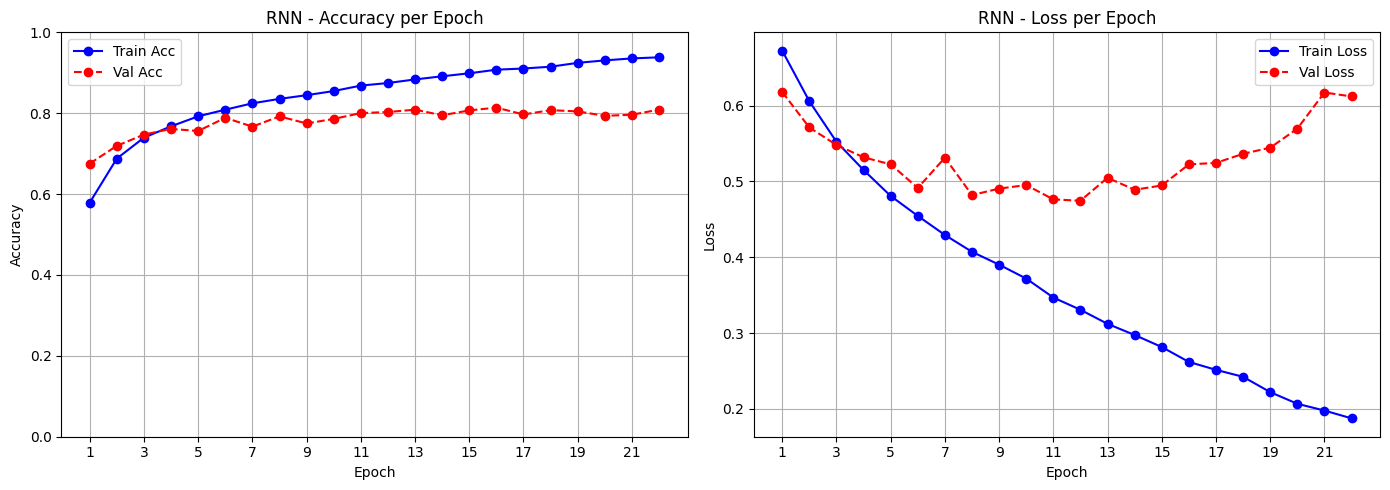

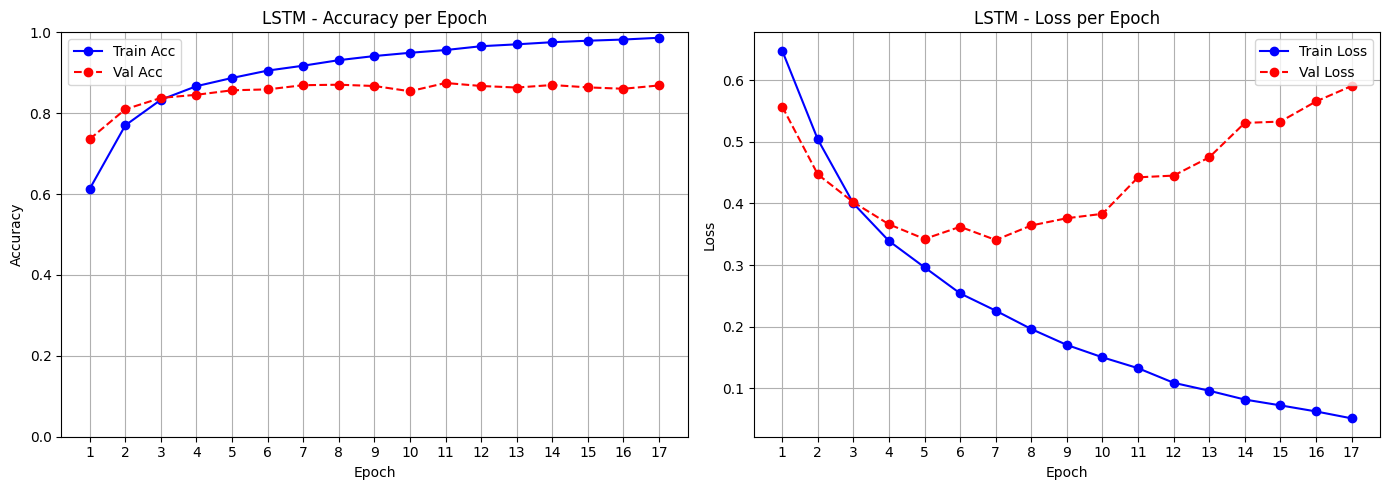

In [ ]:
def plot_training_history(title, train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
def plot_training_history(title, train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'b-o', label='Train Acc')
    plt.plot(epochs, val_accuracies, 'r--o', label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy per Epoch')
    plt.xticks(epochs if len(epochs) <= 20 else range(1, len(epochs)+1, len(epochs)//10))  # auto tick spacing
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
    plt.plot(epochs, val_losses, 'r--o', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss per Epoch')
    plt.xticks(epochs if len(epochs) <= 20 else range(1, len(epochs)+1, len(epochs)//10))
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history('RNN', rnn_train_losses, rnn_val_losses, rnn_train_accuracies, rnn_val_accuracies)
plot_training_history('LSTM', lstm_train_losses, lstm_val_losses, lstm_train_accuracies, lstm_val_accuracies)

<img src="https://drive.google.com/uc?id=1cIfpWj_DxayK7301gf5je16ZZwAIN8jx" width="435">

<img src="https://drive.google.com/uc?id=19-MQkxsghzJTxZLJl59LDc6w87YFd2LY" width="400">


<img src="https://drive.google.com/uc?id=16ZZzYpfaeGZsunbwbJYIKu6NKrzo77BF" width="400">





### Gradient per-Epoch per-Layer Plot

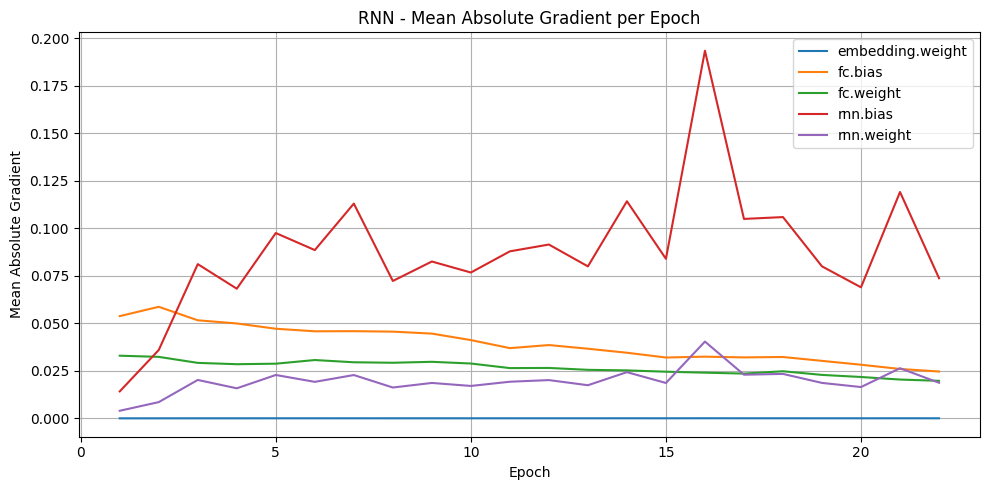

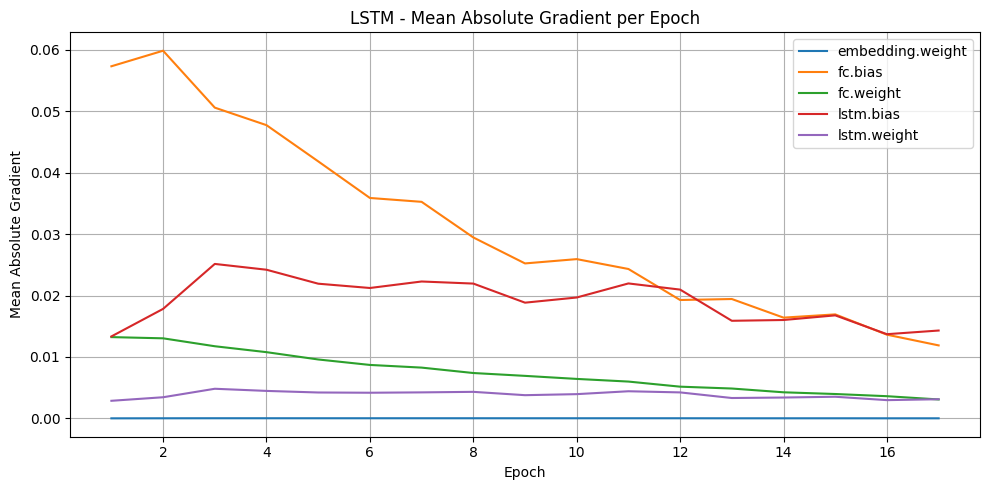

In [ ]:
def extract_component_category(param_name):
    """
    Ambil kategori gabungan: jenis layer + jenis parameter
    e.g. 'embedding.weight' → 'embedding.weight'
         'rnn.weight_ih_l0' → 'rnn.weight'
         'lstm.bias_hh_l0_reverse' → 'rnn.bias'
         'fc.weight' → 'fc.weight'
    """
    name = param_name.lower()

    # Tentukan jenis layer
    if 'embedding' in name:
        layer_type = 'embedding'
    elif 'rnn' in name:
        layer_type = 'rnn'
    elif 'lstm' in name:
         layer_type = 'lstm'
    elif 'fc' in name or 'linear' in name:
        layer_type = 'fc'
    else:
        layer_type = 'other'

    # Tentukan jenis parameter
    if 'weight' in name:
        param_type = 'weight'
    elif 'bias' in name:
        param_type = 'bias'
    else:
        param_type = 'other'

    return f"{layer_type}.{param_type}"

def plot_gradient_history(title, grad_history, components_to_plot=None):
    if not grad_history:
        print("No gradient history available.")
        return

    # Kelompokkan dan hitung rata-rata per kategori
    component_history = []

    for epoch in grad_history:
        grouped = defaultdict(list)
        for name, grad in epoch.items():
            category = extract_component_category(name)
            grouped[category].append(grad)

        # Rata-rata setiap komponen
        epoch_avg = {cat: sum(vals) / len(vals) for cat, vals in grouped.items()}
        component_history.append(epoch_avg)

    # Ambil semua kategori
    all_categories = sorted(component_history[0].keys())
    components = components_to_plot or all_categories

    # Plot
    plt.figure(figsize=(10, 5))
    for cat in components:
        values = [epoch.get(cat, 0.0) for epoch in component_history]
        plt.plot(range(1, len(values) + 1), values, label=cat)

    plt.title(f"{title} - Mean Absolute Gradient per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Gradient")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_gradient_history('RNN', rnn_grad_history)
plot_gradient_history('LSTM', lstm_grad_history)


<img src="https://drive.google.com/uc?id=1qMFl-_vpcUuyrqHxcMvO7X4rl8xw3ysI" width="600">

Visualisasi magnitudo gradien per layer menunjukkan bahwa LSTM mempertahankan gradien yang stabil dan efisien sepanjang pelatihan, sedangkan RNN mengalami fluktuasi besar dan indikasi vanishing gradient. Ini memperkuat pemahaman teoretis bahwa LSTM lebih baik dalam menangani long-term dependencies.

### Evaluasi di Data Test

<Figure size 500x500 with 0 Axes>

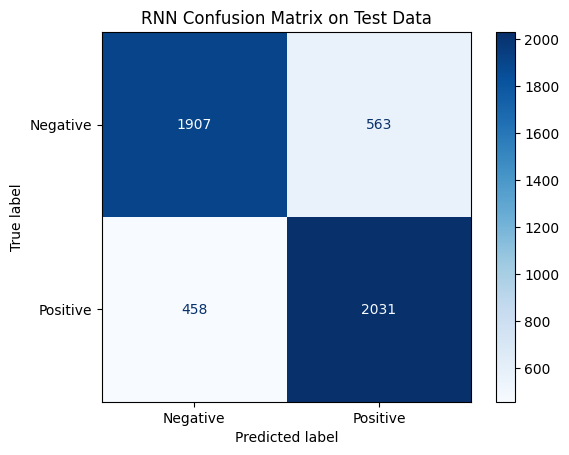


Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.77      0.79      2470
    Positive       0.78      0.82      0.80      2489

    accuracy                           0.79      4959
   macro avg       0.79      0.79      0.79      4959
weighted avg       0.79      0.79      0.79      4959



<Figure size 500x500 with 0 Axes>

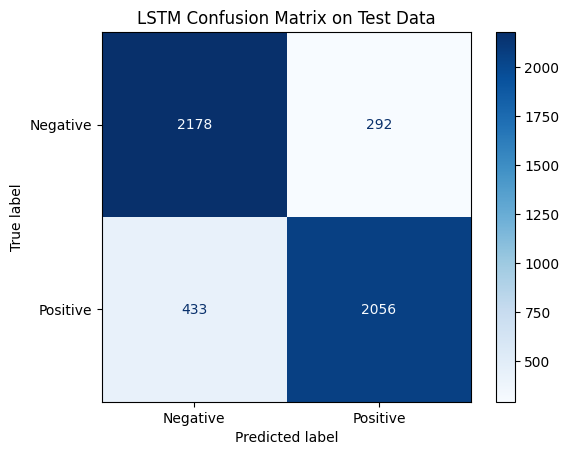


Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.88      0.86      2470
    Positive       0.88      0.83      0.85      2489

    accuracy                           0.85      4959
   macro avg       0.85      0.85      0.85      4959
weighted avg       0.85      0.85      0.85      4959



In [ ]:
def evaluate_on_test(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).float()

            outputs = model(batch_X)
            preds = torch.round(outputs)

            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

    plt.figure(figsize=(5, 5))
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"{model.model_type} Confusion Matrix on Test Data")
    plt.grid(False)
    plt.show()

    # Optional: classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

evaluate_on_test(rnn_model, test_loader, device)
evaluate_on_test(lstm_model, test_loader, device)

<img src="https://drive.google.com/uc?id=1AzV_ZBiI7dVCgdV_Rxpmnd6kitFe0BNc" width="400">

- LSTM outperform RNN dalam hampir semua metrik evaluasi.
- Ini sejalan dengan teori bahwa LSTM lebih baik dalam mempertahankan informasi jangka panjang.
- Selain itu, hasil yang lebih seimbang antara precision dan recall menunjukkan LSTM lebih baik untuk digunakan.



# Analisis Lanjutan

## Masing-Masing Lemah di Data Sepanjang Apa?

In [ ]:
def get_misclassified_samples(model, dataloader, df, device):
    model.eval()
    texts = []
    clean_texts = []
    true_labels = []
    pred_labels = []
    confidences = []

    with torch.no_grad():
        for i, (batch_X, batch_y) in enumerate(dataloader):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).float()
            outputs = model(batch_X)
            preds = torch.round(outputs)

            for j in range(len(batch_y)):
                true = int(batch_y[j].item())
                pred = int(preds[j].item())
                prob = float(outputs[j].item())

                if true != pred:
                    # Hitung indeks global dari data asli (bukan batch)
                    idx = i * dataloader.batch_size + j
                    if idx < len(df):
                        texts.append(df.iloc[idx]['review'])
                        clean_texts.append(df.iloc[idx]['clean_review'])  # ⬅️ kolom tambahan
                        true_labels.append(true)
                        pred_labels.append(pred)
                        confidences.append(prob)

    result_df = pd.DataFrame({
        'review': texts,
        'clean_review': clean_texts,
        'true_label': true_labels,
        'predicted_label': pred_labels,
        'confidence': confidences
    })

    return result_df

false_rnn_df = get_misclassified_samples(rnn_model, test_loader, test_df, device)
false_lstm_df = get_misclassified_samples(lstm_model, test_loader, test_df, device)

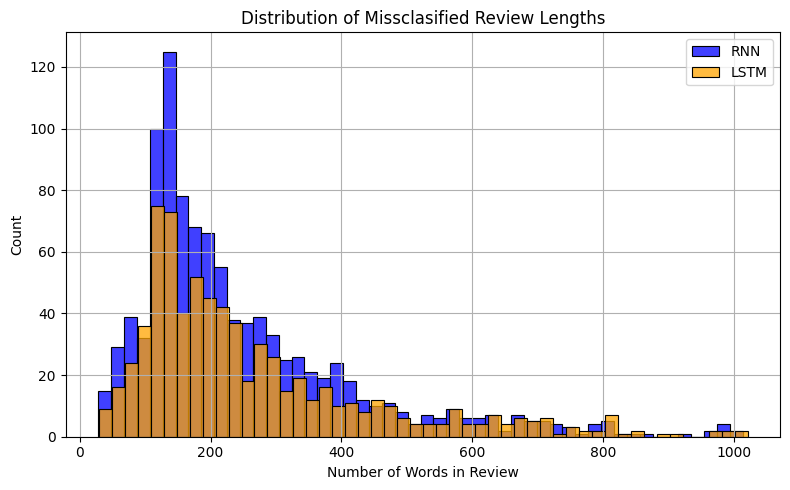

In [ ]:
# Hitung panjang teks
len_false_rnn = false_rnn_df['review'].apply(lambda x: len(x.split()))
len_false_lstm = false_lstm_df['review'].apply(lambda x: len(x.split()))
len_clean_false_rnn = false_rnn_df['clean_review'].apply(lambda x: len(x.split()))
len_clean_false_lstm = false_lstm_df['clean_review'].apply(lambda x: len(x.split()))

# Plot histogram - Original Review
plt.figure(figsize=(8, 5))
sns.histplot(len_false_rnn, bins=50, label='RNN', color='blue', kde=False)
sns.histplot(len_false_lstm, bins=50, label='LSTM', color='orange', kde=False)
plt.title("Distribution of Missclasified Review Lengths")
plt.xlabel("Number of Words in Review")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# # Plot histogram - Cleaned Review
# plt.figure(figsize=(8, 5))
# sns.histplot(len_clean_false_rnn, bins=50, label='RNN (cleaned)', color='green', kde=False)
# sns.histplot(len_clean_false_lstm, bins=50, label='LSTM (cleaned)', color='red', kde=False)
# plt.title("Distribution of Review Lengths (Cleaned)")
# plt.xlabel("Number of Words in Cleaned Review")
# plt.ylabel("Count")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

- RNN lebih banyak melakukan kesalahan pada review panjang, terutama di atas 400 kata, dan bahkan ada hingga >1000 kata.
- LSTM juga mengalami kesalahan, namun cenderung pada review yang lebih pendek atau sedang (sekitar 100–300 kata).
- Review sangat panjang (>600 kata) hampir hanya salah oleh RNN, bukan LSTM.

Ini menunjukkan kelemahan RNN dalam memproses data sequence panjang. LSTM, dengan cell state dan mekanisme gate-nya, lebih mampu mempertahankan konteks dalam teks panjang, sehingga lebih jarang salah dalam review panjang.

## LSTM Unggul di mana?

In [ ]:
def get_combined_misclassified_df(rnn_model, lstm_model, dataloader, df, device):
    rnn_model.eval()
    lstm_model.eval()

    all_reviews = []
    all_clean_reviews = []
    all_true_labels = []
    all_pred_rnn = []
    all_pred_lstm = []
    all_conf_rnn = []
    all_conf_lstm = []

    with torch.no_grad():
        for i, (batch_X, batch_y) in enumerate(dataloader):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).float()

            out_rnn = rnn_model(batch_X)
            out_lstm = lstm_model(batch_X)

            pred_rnn = torch.round(out_rnn)
            pred_lstm = torch.round(out_lstm)

            for j in range(len(batch_y)):
                idx = i * dataloader.batch_size + j
                if idx < len(df):
                    true = int(batch_y[j].item())
                    pr_rnn = int(pred_rnn[j].item())
                    pr_lstm = int(pred_lstm[j].item())
                    conf_rnn = float(out_rnn[j].item())
                    conf_lstm = float(out_lstm[j].item())

                    # Masukkan hanya jika minimal satu model salah prediksi
                    if (pr_rnn != true) or (pr_lstm != true):
                        all_reviews.append(df.iloc[idx]['review'])
                        all_clean_reviews.append(df.iloc[idx]['clean_review'])
                        all_true_labels.append(true)
                        all_pred_rnn.append(pr_rnn)
                        all_pred_lstm.append(pr_lstm)
                        all_conf_rnn.append(conf_rnn)
                        all_conf_lstm.append(conf_lstm)

    final_df = pd.DataFrame({
        'review': all_reviews,
        'clean_review': all_clean_reviews,
        'true_label': all_true_labels,
        'predicted_rnn': all_pred_rnn,
        'predicted_lstm': all_pred_lstm,
        'confidence_rnn': all_conf_rnn,
        'confidence_lstm': all_conf_lstm
    })

    return final_df

misclassified_df = get_combined_misclassified_df(rnn_model, lstm_model, test_loader, test_df, device)
misclassified_df['len_review'] = misclassified_df['review'].apply(lambda x: len(x.split()))
# misclassified_df

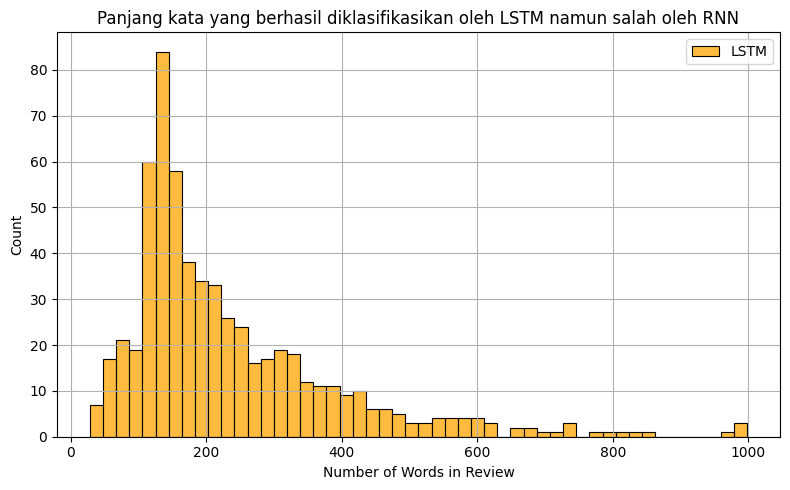

In [ ]:
rnn_benar = misclassified_df[misclassified_df['true_label'] == misclassified_df['predicted_rnn']]
lstm_benar = misclassified_df[misclassified_df['true_label'] == misclassified_df['predicted_lstm']]

# Plot histogram - Original Review
plt.figure(figsize=(8, 5))
sns.histplot(lstm_benar['len_review'], bins=50, label='LSTM', color='orange', kde=False)
plt.title("Panjang kata yang berhasil diklasifikasikan oleh LSTM namun salah oleh RNN")
plt.xlabel("Number of Words in Review")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Histogram di atas merupakan Histogram yang menunjukan Panjang kata yang berhasil diklasifikasikan benar oleh LSTM namun salah oleh RNN. Terlihat bahwa LSTM mampu dengan benar mengklasifikasikan review yang salah diklasifikasikan oleh RNN yang rata-rata banyak kata pada review nya sekitar 250an kata. bahkan masih mampu mengklasifikasikan dengan benar review yang banyak katanya di atas 800

# Kesimpulan

LSTM terbukti jauh lebih superior dibandingkan RNN untuk analisis sentimen pada dataset IMDB. Keunggulan utamanya adalah kemampuan LSTM dalam mengatasi vanishing gradient, masalah yang nyata terjadi pada RNN. Hal ini membuat LSTM lebih andal dalam memahami konteks pada review teks yang panjang, sehingga menghasilkan akurasi yang lebih tinggi dan seimbang.